# CNN Classifier for Plant Waves 
----

#### Preprocessing
In this step, we compute the MFCC matrix, create MFCC images, reshape it to 224x224 images, and store them to disk with labels corresponding to classes and the number of sample. 

In [13]:
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from python_speech_features import mfcc
from PIL import Image
from tqdm import tqdm

%run ../src/utils/constants.py

In [3]:
batch_size = 32

Load raw data.

In [4]:
path_to_pickle = DATASETS_DIR / "sdm_2023-01_all_valid_files_version_1.pkl"
with open(path_to_pickle, 'rb') as file:
    raw_data = pickle.load(file)

While ignoring the class `Neutral`, separate wave slices and labels, and create a Tensor dataset. 

In [5]:
# Helper function for mapping labels to integers.
def map_label_to_int(emotion: str):
    return EKMAN_NEUTRAL_TO_INT_DICT[emotion]

In [6]:
wav_slices = []
labels = []
for segment in raw_data:
    if segment["label"] != "Neutral":
        wav_slices.append(segment["wav_slice"])
        labels.append(map_label_to_int(segment["label"]))

wav_slices = torch.tensor(np.array(wav_slices), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.long)
dataset = TensorDataset(wav_slices, labels)

Normalize the samples using per-sample normalization.

In [7]:
data_tensor, labels_tensor = dataset.tensors
mean = torch.mean(data_tensor, dim=1, keepdim=True)
std_dev = torch.std(data_tensor, dim=1, keepdim=True)
standardized_data = (data_tensor - mean) / (std_dev + 0.00000001)  # smoothing term to prevent zero division

dataset = TensorDataset(standardized_data, labels_tensor)

Extract the MFCC features and save the MFCC plots to disk as `.png`. Create the lists `ids`, `features`, `labels` to be able to split MFCC images into train, test, val datasets as done for the FCNN case. 


In [8]:
ids = []
features = []
labels = []

if not os.path.exists(MFCC_IMAGES_DIR):
    os.mkdir(MFCC_IMAGES_DIR)

count = 0 
for wav_slice, label in tqdm(dataset):
    mfcc_features = mfcc(wav_slice, samplerate=10000, winlen=0.025, winstep=0.010, numcep=26)

    file_name = f"{count}_mfcc_class_{label}.png"

    if not os.path.exists(os.path.join(MFCC_IMAGES_DIR, file_name)):
        plt.imshow(mfcc_features)
        plt.axis("off")
        plt.savefig(os.path.join(MFCC_IMAGES_DIR, file_name), bbox_inches='tight', pad_inches=0)
        plt.close()

    ids.append(count)
    features.append(mfcc_features)
    labels.append(label)
    
    count += 1

100%|███████████████████████████████████| 17329/17329 [00:49<00:00, 347.88it/s]


Create a dictionary `data_split_dict` to keep the mapping between ids and generated MFCC images. 

In [9]:
data_split_dict = {}
for id_value, feature, label in zip(ids, features, labels):
    data_split_dict[id_value] = {'features': feature, 'label': label}

Prepare the data for the CNN.

In [15]:
# Load all MFCC images and file names. 
images = []
file_names = []

image_filenames = os.listdir(MFCC_IMAGES_DIR)
image_paths = [os.path.join(MFCC_IMAGES_DIR, filename) for filename in image_filenames]

IMAGE_SIZE = (97,97)
N_CHANNELS = 3  # rgb
for path in tqdm(image_paths): 
    file_name = os.path.basename(path)
    img = Image.open(path)
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0
    images.append(img_array)
    file_names.append(file_name)

100%|███████████████████████████████████| 17329/17329 [00:56<00:00, 305.86it/s]


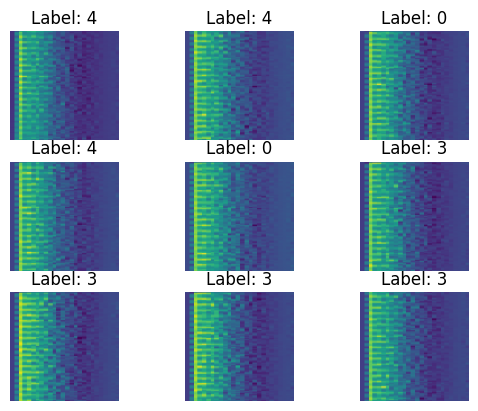

In [16]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()

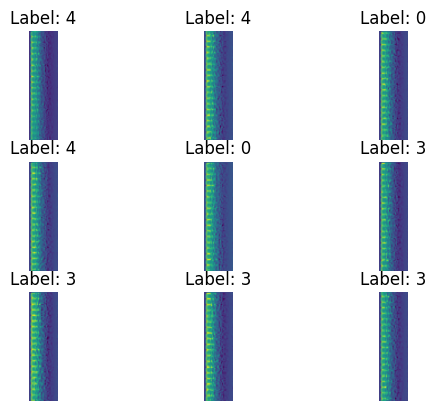

In [14]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()

Create datasets.

#### Training the CNN.

#### Hyperparameter Optimization

#### Training the Classifier

#### Testing the Classifier